In [1]:
"""
OBJETIVO : Seleccionar una muestra de datos para el entrenamiento. Este proceso se realiza por cada 
            modelo (Regresion y clasifiacion). Ademas, se realiza una limpieza de datos, y se divide
            el DS para lso modelos de clasifiacion, para asi balancear las calses.
            
"""

'\nOBJETIVO : Seleccionar una muestra de datos para el entrenamiento. Este proceso se realiza por cada \n            modelo (Regresion y clasifiacion). Ademas, se realiza una limpieza de datos, y se divide\n            el DS para lso modelos de clasifiacion, para asi balancear las calses.\n            \n'

In [2]:
# Leer imagenes satelitales (.nc) 
from netCDF4 import Dataset, num2date

# Graficos y visualizaciones
import cartopy.crs as ccrs
import cartopy.feature as cfw
import matplotlib.pyplot as plt

# Liberias para manejo de datos
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Liberias estandar
import re
import time
import os

In [3]:
"""
DEFINIMOS EL PATH DEL PROYECTO 
"""
with open('../../path_base.txt') as f:
    path_base = f.read()
path_base

'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/NewTesis'

In [4]:
path_imagenes = 'F:/GOES/' 

dsName = 'dsCompletoPP'
listDataset = [f'{path_base}/Archivos/Inicial/{dsName}.csv']           

#Variables generales
products = ['C07','C08','C13']
times   = ['10','20','30','40','50','00']

In [5]:
#Para un conjunto de estaciones (dataframe), agrega su posicion XO(longitud), XA(latitud)

#Como input recibe un string que es el directoeio de una imagen satelital (.nc),
#devuelve la matriz que representa esta imagen numpy.array(1200,950)
def getMapFile(imagenFile):    
    try:
        ds = Dataset(imagenFile)      
    except:
        print("No se pudo leer los archivos de imagen")
        print(imagenFile)
        return -1,-1

    # obtiene las coordenadas de los pixeles
    lons = ds.variables['longitude'][:].data
    lats = ds.variables['latitude'][:].data            
        
    return lons, lats  

#Busca el valor X en el array, devuelve su posicion
def getPosMap(x,array):    
    pos = -1
    for i in range(len(array)):
        if abs(array[i]-x)<=0.01:
            pos = i
            
    return  pos  

#en el la imagen satelital
def changeOrigenStation(estaciones,imagenFile):
    try:
        station = pd.read_csv(estaciones)   
    except:
        print("No se pudo leer el  archivos de estaciones")
        return False
    
    lo,la = getMapFile(imagenFile)
    
    station['XO'] = station.apply(lambda x: getPosMap(float(x['LON']), lo),axis=1)
    station['XA'] = station.apply(lambda x: getPosMap(float(x['LAT']), la),axis=1)    
    
    
    return station    

In [6]:
#Obtiene los datos de precipitacion de un archivo csv, los procesa y los guarda en OTRO archivo CSV
#regresa la cantidad de estaciones sin datos de precipitaciones
def procesarDatos(path_base,estaciones,valores,imagenFile,noFLAG,nameOut, umbral=False):  
    start_time = time.time()
    #Obtenemos la informacion de los archivos
    #"Valores"  Contiene los valores de los datos de precipitacion de manera horaria por estacion (codigo)
    #"estaciones" Contiene los daots de cada estacion (cordenadas,codigo,etc)  
    try:        
        values = pd.read_csv(valores,encoding='latin-1')    
    except:
        print("No se pudo leer el archivos de valores")
        return False
    station = changeOrigenStation(estaciones,imagenFile)
    
    
    #Lista de [nombre,codigo,xo,xa,longitud,latitud,altura,dato,año,mes,dia,hora,flag]
    resultado = []
    
    #Numero filas
    n = len(values.index) 
    
    #Auxiliares
    total = n
    completados = 1 
    
    noStation = {}
    
    for i in range(n):
        #Codigo de estacion
        cod = values['CODIGO'][i]        
        st = station[station['Codigo'] == f'X{cod}']
        if st.empty:            
            st = station[station['Nombre'] == values['NOMBRE'][i]]
        if st.empty:
            noStation[cod] = values['NOMBRE'][i]
            
        if not st.empty:       
            flag = values['FLAG'][i]
            
            if flag not in noFLAG:
                #Datos de estacion
                nombre = st['Nombre'].iloc[0]
                xo = st['XO'].iloc[0]
                xa =  st['XA'].iloc[0]
                lat = st['LAT'].iloc[0]
                lon = st['LON'].iloc[0]
                alt = st['ALT'].iloc[0]
                
                _90 = st['90%'].iloc[0]
                _99 = st['99%'].iloc[0]
                _75 = st['75%'].iloc[0]
                
                flagV2 =  values['FLAGV2'][i]
                #Datos de precipitacion
                dato = values['PRECIPITACION'][i]        
                day, month , year = values['FECHA'][i].split('/')   
                hour = values['HORA'][i].split(':')[0]                    

                resultado.append([nombre,cod,xo,xa,lon,lat,alt,dato,_90,_99,_75,f'{year}-{month}-{day}-{hour}',flag,flagV2])
                completados = completados + 1
        
        if not completados % 100000:
            progreso = completados/total*100
            print(f'Estaciones con Error: {len(noStation)}')
            f = '{0:.3g}'.format(progreso)
            print(f"Procesando - {f}%")
    
    print(f"Tiempo tomado en procesar {completados}/{n} datos: %.5fs" % (time.time() - start_time))
    start_time = time.time()
    
    #Guardamos en un csv los datos 
    print("Guardando los datos al archivo dataset....")
    df = pd.DataFrame(resultado, columns = ['nombre','codigo','XO','XA','longitud','latitud','altura','dato','90%','99%','75%','fecha','flag','flagV2'])
    df.to_csv(f'{path_base}/Archivos/Inicial/{nameOut}.csv', index=False)
    print(f"Tiempo tomado en guardar {completados}datos: %.5fs" % (time.time() - start_time))
    return noStation, df
    

In [7]:
"""
Procesamos los datos de precipitacion para cada año
"""

'\nProcesamos los datos de precipitacion para cada año\n'

In [8]:
#Variables
Festaciones = f'{path_base}/Archivos/Inicial/estaciones.csv'
FflagV2 = f'{path_base}/Archivos/Dataset/dsFLAGV2.csv'

imagenTest = 'F:/GOES/C08/2021/01/G16_C08_Cyl_20210101-0020.nc'
Fanalisis = f'{path_base}/Archivos/Reportes/Datos/analisis_2021.csv'

#Flag que se borran del dataset
noFLAG = ['M0000001','M0000001, M0110302','M0110302','ND']
dsName = 'dsCompletoPP'

In [9]:
"""
FLAGV2 
"""
noStationFV2, datosFLAGV2 = procesarDatos(path_base,Fanalisis,FflagV2,imagenTest,noFLAG,nameOut=dsName, umbral=True)

datosFLAGV2 = pd.read_csv(f'{path_base}/Archivos/Inicial/{dsName}.csv')
datosFLAGV2.head(4)

,nombre,codigo,XO,XA,longitud,latitud,altura,dato,90%,99%,75%,fecha,flag,flagV2
0,ALAMOR,47E0D438,175,325,-80.39788,-4.48047,116.0,0.0,0.0,0.9,0.0,2021-01-01-00,C0000001,C01
1,ALAMOR,47E0D438,175,325,-80.39788,-4.48047,116.0,0.0,0.0,0.9,0.0,2021-01-01-01,C0000001,C01
2,ALAMOR,47E0D438,175,325,-80.39788,-4.48047,116.0,0.0,0.0,0.9,0.0,2021-01-01-02,C0000001,C01
3,ALAMOR,47E0D438,175,325,-80.39788,-4.48047,116.0,0.0,0.0,0.9,0.0,2021-01-01-03,C0000001,C01


In [9]:
datosFLAGV2['flagV2'].unique()

array(['C01', 'D02', 'D01', 'NC', 'ND', 'M01'], dtype=object)

In [10]:
"""
Limpiamos el dataset
"""

'\nLimpiamos el dataset\n'

In [10]:
#Del dataset guardamos los datos mas importantes en una columna para facilitar su lectura
def obtenerDir(row):
    fecha = row['fecha']

    year, month, day, hour = fecha.split('-')
    # filename = f'{path_base}comprimido/{year}_{month}_{day}/{hour}/'
    return f"{row['XO']}--{row['XA']}--{fecha}"

In [11]:

#Lee el archivo "filename" de datos de precipitacion y
#regresa un df que facilite la lectura del dataset para el entrenmaiento
def obtenerDatos(filename):
    start_time = time.time()
    pdata = pd.read_csv(filename)
    
    # Quitamos los valores NA
    pdata = pdata[pdata['dato'].notna()]

    # Definimos un solo tipo (str) pora asi poder convertirlo a tensor
    pdata = pdata.astype({"dato": str, "XO": str, "XA": str, "fecha": str})

    #Definimos la nueva columna para guardar el XO, XA y fecha
    pdata['imagen'] = pdata.apply(obtenerDir, axis=1)

    # Seleccionamos solo las columnas necesarias :
    # precipitacion, Estacion (Longitud), Estacion (Latitud), Fecha (año-mes-dia-hora)
    #pdataX = pdata.loc[:, ['dato','umbral','altura', 'imagen', 'fecha']]
    pdata = pdata.astype({"dato": str, "umbral": str, "altura": str, "imagen": str, "fecha": str})

    # Barajeamos los datos
    pdata = shuffle(pdata)

    print(f'{len(pdata)} datos leidos')
    print("Tiempo tomado en leer datos: %.2fs" % (time.time() - start_time))
    return pdata

In [12]:
# Devuelve una lista con lo indices que no se encontraron lso archivos y el producto
# Servira para ver si se teinen todas los frames de la fecha
def comprobarFrames(dfOrignial, path_base, products, times, delete=1):
    
    #dfOrignial = obtenerDatos(datafile)
    
    
    start_time = time.time()
    
    dfTotal = pd.unique(dfOrignial['fecha'])
    no_fecha = []
    for fecha in dfTotal:
        year, month, day, hour = fecha.split('-')
        existe = True
        for p in products:
            for t in range(len(times)):             
                filename = f'{path_base}PNG/{fecha}/{fecha}_{t}.png'
                try:                    
                    file_size = os.path.getsize(filename)
                    existe = file_size > 4100000
                except: 
                    existe = False
                    break
                
            if not existe:
                break
        if not existe:
            no_fecha.append(fecha)
            

    if delete:
        antes = len(dfOrignial)
        df2 = dfOrignial[~dfOrignial['fecha'].isin(no_fecha)]
        despues = len(df2)
        print(f'{antes - despues}/{antes} datos eliminados: No se encontraron los archivos de imagenes satelitales')
    else:
        df2 = dfOrignial

    print("Tiempo tomado en verificar datos: %.2fs" % (time.time() - start_time))
    return df2, no_fecha

In [13]:
def getBalancedDataset(df,porc):
    listP = []
    listT = []    
    
    df0 = df[df['dato']==0]
    df01 = df[(df['dato']>0) & (df['dato']<=1)]
    df1 = df[df['dato']>1]
    
    if not df0.empty:
        dsT0, dsP0 = train_test_split(df0, test_size=porc, shuffle=True)  
        listT.append(dsT0)
        listP.append(dsP0)        
        
    if not df01.empty:
        dsT1,dsP1 = train_test_split(df01, test_size=porc, shuffle=True)
        listT.append(dsT1)
        listP.append(dsP1)
        
    if not df1.empty:
        dsT_, dsP_ =  train_test_split(df1, test_size=porc, shuffle=True)
        listT.append(dsT_)
        listP.append(dsP_)
    
   
    dfTrain = pd.concat(listT, ignore_index=True) 
    dfPrueba = pd.concat(listP, ignore_index=True)
    return dfTrain, dfPrueba    

In [14]:
def obtenerDSPruebas(df, porc, tipo='Clasificacion'):
    """
    Separamos el dataset en 3 partes, y se ecoje un porcentaje de los tres
    - Datos : 0
    - Dato  : < 0,1 ]
    - Dato  : <1 , --]
    """
    
    if tipo=='Clasificacion':
        dfC02 = df[df['flag']=='C0000002'] 
        dfM02 = df[df['flag']=='M0000002']
    
        C02T,C02P = getBalancedDataset(dfC02,porc)
        M02T,M02P = getBalancedDataset(dfM02,porc)   
    
   
        dfTrain = pd.concat([C02T,M02T], ignore_index=True) 
        dfPrueba = pd.concat([C02P,M02P], ignore_index=True) 
        
        return dfTrain, dfPrueba
        
    else:        
        return getBalancedDataset(df,porc)
    
    return -1

In [15]:
def limpiarDatos(listNames, path_imagenes, p, read=True):
    
    df = []
    start_time = time.time()
    print(f'Se leera los archivos de datasets...')
    if read:
        for name in listNames:
            try:
                df.append(pd.read_csv(name))   
            except:
                print(f'No se pudo leer el archivo {name} de dataset')
                return -1

        if len(df)>1:
            dsCompleto =  pd.concat(df, ignore_index=True) 
        else:
            dsCompleto =  df[0]
    else:
        dsCompleto = listNames
        
        
    print("Tiempo tomado: %.2fs" % (time.time() - start_time))
    print(f'+Cantidad de datos leidos {len(dsCompleto)}')
    
    # Quitamos los NA valores, negativos y mayores a 400
    print(f'\nSe elimnara los valores nulos y dudosos')
    dsCompleto.dropna(subset=['dato'], axis='index', inplace=True)    
    dsCompleto = dsCompleto[dsCompleto['flag']!='ND']
    #dsCompleto = dsCompleto[dsCompleto['dato']>=0]
    dsCompleto = dsCompleto[dsCompleto['dato']<400]
    print("Tiempo tomado: %.2fs" % (time.time() - start_time))
    print(f'+Cantidad de datos luego de elimnar nulos {len(dsCompleto)}')
              
    
    # Seleccionamos FLAGS
    if p['flags']:
        dsCompleto = dsCompleto[dsCompleto['flag'].isin(p['flags'])]    
    if p['flagV2']:
        dsCompleto = dsCompleto[dsCompleto['flagV2'].isin(p['flagV2'])]    
    
    
    # Buscamos imagenes satelitales para lso archivos
    print(f'\nSe buscara las imagenes satelitales para los datos...')
    dfImagenes, no_fecha = comprobarFrames(dsCompleto, path_imagenes, p['products'], p['times'], p['delete'])    
    print("Tiempo tomado: %.2fs" % (time.time() - start_time))
               
        
    # Limitamos la cantidad de ceros
    if p['ceros']:
        print(f'\nSe limitara el numero de ceros al {p["ceros"]*100:.2f} porciento...')
        dsNoNulo = dfImagenes[dfImagenes['dato']!=0]
        dsNulo = dfImagenes[(dfImagenes['dato']==0)&(dfImagenes['flag'].isin(['C0000002','C0000001']))]
        dsNulo = dsNulo.sample(frac=p['ceros'])#n=int(p['ceros']*len(dsNoNulo)))        
        dfImagenes = pd.concat([dsNoNulo,dsNulo], ignore_index=True) 
        print(f'+Cantidad de datos luego de limtar ceros {len(dfImagenes)}')
            
    #Agregamos lso datos de las estaciones al dataset
    print(f'\nSe agregara los datos de las estaciones(cordenadas, umbral)...')
    dfImagenes['imagen'] = dfImagenes.apply(obtenerDir, axis=1)        
    print(f'-------> CANTIDAD FINAL DE DATOS :  {len(dfImagenes)} <--------------')  
    print("Tiempo total: %.2fs" % (time.time() - start_time))
    return shuffle(dfImagenes), no_fecha

In [16]:
def getModelo_DS(listNames, path_imagenes, p,comentario='', read=True):
    print(f'Tipo de dataset: {p["redTipo"]}')
    # Limpiamos en dataset
    dfLimpio, no_fecha = limpiarDatos(listNames, path_imagenes, p, read)
    dfLimpio.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/{p["nameDS"]}_CompletoDS.csv')
    
    if p['estaciones']:
        print(f'Se limitara el DS a {len(p["estaciones"])} estaciones')
        dfLimpio = dfLimpio[dfLimpio['codigo'].isin(p['estaciones'])]
    
    if p['redTipo'] == 'Clasificacion':
        dfLimpio[p['claseName']] = (dfLimpio[p['condicion_1'][0]]==p['condicion_1'][1]).astype(int)       
        
    
    # Separamos los datasets (entrenamiento, validacion y test)
    _dsTrain, _dsTest = obtenerDSPruebas(dfLimpio, p['pruebas'], tipo=p['redTipo']) 
    _dsTrain, _dsValid = obtenerDSPruebas(_dsTrain, p['validacion'], tipo =p['redTipo'])
    
    # Guardamos los archivos    
    _dsTest.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/Pruebas/{p["nameDS"]}_PruebasDS.csv')
    _dsValid.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/Validacion/{p["nameDS"]}_ValidacionDS.csv')
    _dsTrain.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/Entrenamiento/{p["nameDS"]}_TrainDS.csv')
    
    print('Tamaño de los datasets: ')
    print(f'TRAIN   : {len(_dsTrain)}')
    print(f'VALID   : {len(_dsValid)}')
    print(f'PRUEBAS : {len(_dsTest)}')

    # Guardamos el comentario (Informacion de lso datasets)

    with open(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/{p["nameDS"]}_comentario.txt', 'w') as file:
        file.write(f'Archivos iniciales que se uso : {str(listNames)}\n')
        file.write(comentario)
        file.write(' A continuacion se muestra los parametros que se usaron:\n')        
        file.write(str(p))
        
    return dfLimpio

In [17]:
"""
Clasificacion
"""
comentarioCLAS = 'El dataset es para lso modelos de clasificaicon, se usa como clase 1 los datos con flag = C02\
               y todos los flags M02 como clase 0.\n'
p_clas = {    
    # parametros del proyecto
    'products'   : products,
    'times'      : times,
    'path_base'  : path_base,

    # parametros del dataset
    'ceros'      : 0.10,   
    'flags'      : ['C0000002','DIM00001','M0000002'],
    'flagV2'     : ['D01','D02','C01'],    
    'estaciones' : [],
    'delete'     : True,
    
    # Split
    'pruebas'    : 0.01,
    'validacion' : 0.1,
    
    # Modelo
    'redTipo'    : 'Clasificacion',
    
    # PARA MODELOS DE CLASIFICACION
    'claseName'  : 'clase',
    'condicion_1': ['flag','C0000002'],    
    
    # Nombres
    'nameDS'     : 'ClaseV1',       
}

In [19]:
dfLimpioCLAS = getModelo_DS(listDataset, path_imagenes, p_clas,comentario=comentarioCLAS)

Tipo de dataset: Clasificacion
Se leera los archivos de datasets...
Tiempo tomado: 2.67s
+Cantidad de datos leidos 2494399

Se elimnara los valores nulos y dudosos
Tiempo tomado: 3.38s
+Cantidad de datos luego de elimnar nulos 2494216

Se buscara las imagenes satelitales para los datos...
1992/45264 datos eliminados: No se encontraron los archivos de imagenes satelitales
Tiempo tomado en verificar datos: 8.94s
Tiempo tomado: 12.48s

Se limitara el numero de ceros al 10.00 porciento...
+Cantidad de datos luego de limtar ceros 34462

Se agregara los datos de las estaciones(cordenadas, umbral)...
-------> CANTIDAD FINAL DE DATOS :  34462 <--------------
Tiempo total: 13.00s
Tamaño de los datasets: 
TRAIN   : 30699
VALID   : 3414
PRUEBAS : 347


           ESTADISCIAS DEL DS_CLAS 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 153
Totales     : 34460
Ceros       : 750
Clase 0(M02): 740
Clase 1(C02): 33720
Maximo      : 337.5
Media       : 1.8316433546140456
STD         : 8.024564387680286


<AxesSubplot:>

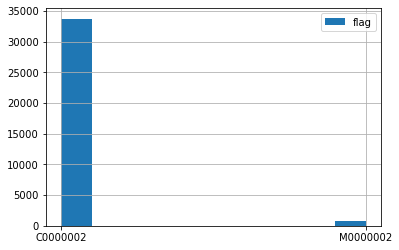

In [27]:
print('           ESTADISCIAS DEL DS_CLAS \n')
dfLimpioCLAS = dfLimpioCLAS[dfLimpioCLAS['flag']!='DIM00001']
print(f'Flags       : {dfLimpioCLAS["flag"].unique()}')
print(f'Estaciones  : {len(dfLimpioCLAS["codigo"].unique())}')
print(f'Totales     : {dfLimpioCLAS["dato"].count()}')
print(f'Ceros       : {dfLimpioCLAS[dfLimpioCLAS["dato"]==0]["dato"].count()}')
print(f'Clase 0(M02): {dfLimpioCLAS[dfLimpioCLAS["flag"]=="M0000002"]["dato"].count()}')
print(f'Clase 1(C02): {dfLimpioCLAS[dfLimpioCLAS["flag"]=="C0000002"]["dato"].count()}')
print(f'Maximo      : {dfLimpioCLAS["dato"].max()}')
print(f'Media       : {dfLimpioCLAS["dato"].mean()}')
print(f'STD         : {dfLimpioCLAS["dato"].std()}')

#_dataset[_dataset["dato"]!=0]["dato"].hist(legend=True)
#_dataset[_dataset["dato"]>1]["dato"].hist(legend=True)
dfLimpioCLAS['flag'].hist(legend=True)

In [22]:
"""
Regresion
"""
comentarioREG = 'El dataset es para lso modelos de regresion, se usa como output el dato \
            Se ha realizado una limpieza de datos (quitado datos malos 1 y verificado que exista \
            las imagenes satelitales). Ademas se ha validado con el flagV2 los datos erroneos'

p_reg = {    
    # parametros del proyecto
    'products'   : products,
    'times'      : times,
    'path_base'  : path_base,

    # parametros del dataset
    'ceros'      : 0.10,   
    'flags'      : ['C0000002'],
    'flagV2'     : ['D01','D02','C01'],   
    'estaciones' : [],
    'delete'     : True,
    
    # Split
    'pruebas'    : 0.01,
    'validacion' : 0.2,
    
    # Modelo
    'redTipo'    : 'Regresion',
    
    # PARA MODELOS DE CLASIFICACION
    'claseName'  : '',
    'condicion_1': [],    
    
    # Nombres
    'nameDS'     : 'DatoV1',       
}

In [23]:
dfLimpioREG = getModelo_DS(listDataset, path_imagenes, p_reg ,comentario=comentarioREG)

Tipo de dataset: Regresion
Se leera los archivos de datasets...
Tiempo tomado: 2.66s
+Cantidad de datos leidos 2494399

Se elimnara los valores nulos y dudosos
Tiempo tomado: 3.34s
+Cantidad de datos luego de elimnar nulos 2494216

Se buscara las imagenes satelitales para los datos...
1837/42305 datos eliminados: No se encontraron los archivos de imagenes satelitales
Tiempo tomado en verificar datos: 3.65s
Tiempo tomado: 7.11s

Se limitara el numero de ceros al 10.00 porciento...
+Cantidad de datos luego de limtar ceros 33720

Se agregara los datos de las estaciones(cordenadas, umbral)...
-------> CANTIDAD FINAL DE DATOS :  33720 <--------------
Tiempo total: 7.60s
Tamaño de los datasets: 
TRAIN   : 26703
VALID   : 6678
PRUEBAS : 339


           ESTADISCIAS DEL DS_REG_1 

Flags       : ['C0000002']
Estaciones  : 152
Totales     : 33720
Ceros       : 750
Entre 0 y 1 : 19330
Mayores a 1 : 793
Maximo      : 66.9
Media       : 1.6386838671411625
STD         : 3.1684947103007484


<AxesSubplot:>

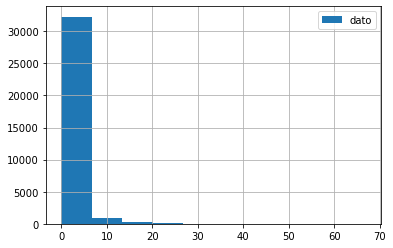

In [40]:
print('           ESTADISCIAS DEL DS_REG_1 \n')

print(f'Flags       : {dfLimpioREG["flag"].unique()}')
print(f'Estaciones  : {len(dfLimpioREG["codigo"].unique())}')
print(f'Totales     : {dfLimpioREG["dato"].count()}')
print(f'Ceros       : {dfLimpioREG[dfLimpioREG["dato"]==0]["dato"].count()}')
print(f'Entre 0 y 1 : {dfLimpioREG[(dfLimpioREG["dato"]>0) & (dfLimpioREG["dato"]<1)]["dato"].count()}')
print(f'Mayores a 1 : {dfLimpioREG[dfLimpioREG["dato"]>10]["dato"].count()}')
print(f'Maximo      : {dfLimpioREG["dato"].max()}')
print(f'Media       : {dfLimpioREG["dato"].mean()}')
print(f'STD         : {dfLimpioREG["dato"].std()}')

#_dataset[_dataset["dato"]!=0]["dato"].hist(legend=True)
#_dataset[_dataset["dato"]>1]["dato"].hist(legend=True)
dfLimpioREG['dato'].hist(legend=True)

In [45]:
"""
VIsualizamos las estaciones
"""

'\nVIsualizamos las estaciones\n'

In [47]:
#Leemos un dato de imagen satelital para obtener las coordenadas
imagenTest = 'F:/GOES/C08/2021/01/G16_C08_Cyl_20210101-0020.nc'
ds = Dataset(imagenTest)
field = ds.variables['CMI'][:].data.astype(np.float32)/100.0

# obtiene las coordenadas de los pixeles
lons = ds.variables['longitude'][:].data
lats = ds.variables['latitude'][:].data
lons, lats = np.meshgrid(lons, lats)

dfEstaciones = pd.read_csv(Festaciones)

In [48]:
dfEstCLAS = dfLimpioCLAS['codigo'].unique()
CLAS = pd.DataFrame({'codigo':dfEstCLAS.tolist()})

dfEstREG = dfLimpioREG['codigo'].unique()
REG = pd.DataFrame({'codigo':dfEstREG.tolist()})

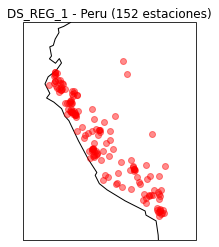

In [53]:
#Graficomos las estaciones para el ds de regresion
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title(f'DS_REG_1 - Peru ({len(REG)} estaciones)')
ax.set_extent([lons.min(), lons.max(), lats.min(),lats.max()], ccrs.PlateCarree())

for x in REG.index:
    st = dfEstaciones[dfEstaciones['CODE'] == f'X{REG["codigo"][x]}']    
    if not st.empty:    
        x = st['LON']#.iloc[0]
        y = st['LAT']#.iloc[0]
        plt.plot(x, y,  1, marker='o', color='red',alpha=0.45)    
    
ax.coastlines(resolution='110m')
#plt.savefig(f'{path_base}/Archivos/Reportes/Plots/MAPA_DS_01(REG-BAL).png')
plt.show()

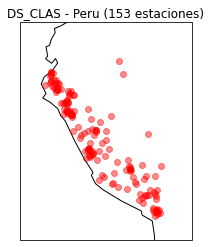

In [54]:
#Graficomos las estaciones para el ds de clasificaicon
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title(f'DS_CLAS - Peru ({len(CLAS)} estaciones)')
ax.set_extent([lons.min(), lons.max(), lats.min(),lats.max()], ccrs.PlateCarree())

for x in CLAS.index:
    st = dfEstaciones[dfEstaciones['CODE'] == f'X{CLAS["codigo"][x]}']    
    if not st.empty: 
        #print(st)
        x = st['LON']#.iloc[0]
        y = st['LAT']#.iloc[0]
        plt.plot(x, y,  1, marker='o', color='red',alpha=0.45)    
    
ax.coastlines(resolution='110m')
#plt.savefig(f'{path_base}/Archivos/Reportes/Plots/MAPA_DS_02(CLAS).png')
plt.show()

In [51]:
"""
Separamos el dataset de entrenamiento para balancear las clases
"""

'\nSeparamos el dataset de entrenamiento para balancear las clases\n'

In [52]:
def applyDA(df, columna='clase', DA=3):
    df['DA'] = 0
    dfs = [df[df[columna]==0], df[df[columna]==1]]    
    posM = 0 if len(dfs[0])>len(dfs[1]) else 1
    
    # Clase minoritaria = M^1
    # Se va aumentar lm
    dfMenor0 = dfs[posM^1].copy()
    
    dfMenor1 = dfs[posM^1].copy()
    dfMenor1['DA'] = 1
    
    dfMenor2 = dfs[posM^1].copy()
    dfMenor2['DA'] = 2
    
    dfMenor3 = dfs[posM^1].copy()
    dfMenor3['DA'] = 3
    
     
    dfMenos = [dfMenor0,dfMenor1,dfMenor2,dfMenor3,dfs[posM]]
    train = pd.concat(dfMenos)    
    
    return train

In [53]:
def splitTrainDS(_dataset, redTipo, path_base, newDir='Split', DA=0, comentario=' '):      
    tipo = redTipo[0]
    output = redTipo[1]
    if DA:
        print('Se le aplicará DA al dataset')
        _dataset = applyDA(_dataset, output, 3)
        
    dfs = [_dataset[_dataset[output]==0], _dataset[_dataset[output]==1]]    
    posM = 0 if len(dfs[0])>len(dfs[1]) else 1
    lM = len(dfs[posM])
    lm = len(dfs[posM^1])
    
    try:
        path = os.path.join(f'{path_base}/Archivos/Dataset/{tipo}/Entrenamiento/', newDir)
        os.mkdir(path)        
    except FileExistsError:
        pass
    except:
        print(f"No se pudo crear la carpeta {newDir}")
    
    
    n = int(lM/lm) + (lM % lm > 0)    
    splitted = []
    
    for i in range(n):
        if i == (n-1):
            tempDF1 = dfs[posM][i*lm:i*lm+lm]
            tempDF2 = dfs[posM][0:i*lm].sample(n=(lm-len(tempDF1)))            
            splitted.append(pd.concat([tempDF1,tempDF2,dfs[posM^1]], ignore_index=True))            
        else:
            tempDF = dfs[posM][i*lm:i*lm+lm]            
            splitted.append(pd.concat([tempDF,dfs[posM^1]], ignore_index=True))
            
    print(f'Se ha divido el dataset en {len(splitted)} partes')
    i = 0    
    for df in splitted:        
        df.to_csv(f'{path_base}/Archivos/Dataset/{tipo}/Entrenamiento/{newDir}/{output.upper()}_TrainDS_{i}.csv')
        i+=1
 
    text_comentario = open(f'{path_base}/Archivos/Dataset/{tipo}/Entrenamiento/{newDir}/comentario.txt', "w")
    text_comentario.write(comentario) 
    text_comentario.close()
    
    return splitted

In [54]:
"""
Variables para el split del DS de clasifaicion
"""
dsV_ = 'ClaseV1_TrainDS.csv'
fileDS = f'{path_base}/Archivos/Dataset/Clasificacion/Entrenamiento/{dsV_}'
dsTrainCLAS = pd.read_csv(fileDS)

In [55]:
# DS CLasificacion, sin DA 
comDA = f"Este dataset es para el modelo de clasificacion con output clase, NO se le esta aplicando DataAugmentation (DA). \
              al dataset se divide en varias partes de tal forma de balancear las clases. Version 1\
              Datset original usado : {fileDS}"

splittedDF = splitTrainDS(dsTrainCLAS,['Clasificacion','clase'], path_base, newDir='SplitSinDA_V1', DA= 0, comentario=comDA)   

Se ha divido el dataset en 46 partes


In [56]:
# DS CLasificacion, con DA 
comNODA = f"Este dataset es para el modelo de clasificacion con output clase, SI se le esta aplicando DataAugmentation (DA) = 3. \
              al dataset se divide en varias partes de tal forma de balancear las clases. Version 1\
              Datset original usado : {fileDS}"

splittedDF = splitTrainDS(dsTrainCLAS,['Clasificacion','clase'], path_base, newDir='SplitConDA_V1', DA= 3, comentario=comNODA)   

Se le aplicará DA al dataset
Se ha divido el dataset en 12 partes


In [57]:
"""
Dataset aplicando criterio de estadisticas
"""

'\nDataset aplicando criterio de estadisticas\n'

In [43]:
"""
Escojemos las mejores estaciones (por cantidad de datos conformes, estadisticas , etc)
"""
analisis2020 = f'{path_base}/Archivos/Reportes/Datos/analisis_2020.csv'
analisis2021 = f'{path_base}/Archivos/Reportes/Datos/analisis_2021.csv'

analisisTotal = f'{path_base}/Archivos/Reportes/Datos/analisis_2021.csv'


dfAna20 = pd.read_csv(analisis2020)
dfAna21 = pd.read_csv(analisis2021)
dfAnaTotal = pd.read_csv(analisisTotal)

dfAnaTotal.head(2)

,count,mean,std,min,25%,50%,75%,max,FechaMax,FechaMin,...,cantM02,cantD01,75mayor,90mayor,90%,99mayor,99%,LON,LAT,ALT
0,8749,0.048531,0.685865,0.0,0.0,0.0,0.0,36.3,31/12/2021,01/01/2021,...,0,0,248,248,0.0,83,0.9,-80.39788,-4.48047,116.0
1,8719,0.048067,0.679521,0.0,0.0,0.0,0.0,36.0,31/12/2021,01/01/2021,...,0,115,232,232,0.0,84,0.7,-80.39014,-4.48956,116.0


In [44]:
bestMean = 30
bestConf = 20

dfMejor = dfAnaTotal.sort_values('mean',ascending=False).head(bestMean)
dfMejor['POR_NO_C01'] = 1 - dfAnaTotal['cantC01'] / dfAna21['count']
dfMejor = dfMejor.sort_values(['cantM01','POR_NO_C01'], ascending=True).head(bestConf)[['Codigo','count','POR_NO_C01','mean','cantM01','cantM02','cantC01','cantC02','cantD01']]

dfMejor.head(2)

,Codigo,count,POR_NO_C01,mean,cantM01,cantM02,cantC01,cantC02,cantD01
191,X47E8201A,6403,0.055911,0.280087,0,0,6045,153,205
176,X114122,1605,0.071651,0.453271,0,0,1490,1,114


In [45]:
"""
dfGraficar = dfMejor[0:19]

#Graficomos las estaciones para el ds de clasificaicon
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title(f'DS_1 (Regresion - EST) - Peru ({len(dfMejor)} estaciones)')
ax.set_extent([lons.min(), lons.max(), lats.min(),lats.max()], ccrs.PlateCarree())

for x in dfGraficar.index:
    st = dfEstaciones[dfEstaciones['CODE'] == f'{dfGraficar["Codigo"][x]}']    
    if not st.empty: 
        #print(st)
        x = st['LON']#.iloc[0]
        y = st['LAT']#.iloc[0]
        plt.plot(x, y,  1, marker='o', color='red',alpha=0.45)    
    
ax.coastlines(resolution='110m')
plt.savefig(f'{path_base}/Archivos/Reportes/Plots/MAPA_DS_01(REG-EST).png')
plt.show()
"""
a=0

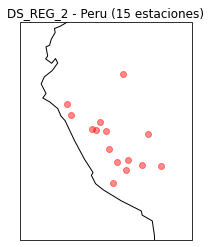

In [56]:

dfLimpioREG_EST['xcodigo'] = 'X' + dfLimpioREG_EST['codigo']
dfGraficar =  dfMejor[dfMejor['Codigo'].isin(dfLimpioREG_EST['xcodigo'].unique().tolist())][0:15]

#Graficomos las estaciones para el ds de clasificaicon
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title(f'DS_REG_2 - Peru ({len(dfGraficar)} estaciones)')
ax.set_extent([lons.min(), lons.max(), lats.min(),lats.max()], ccrs.PlateCarree())

for x in dfGraficar.index:
    st = dfEstaciones[dfEstaciones['CODE'] == f'{dfGraficar["Codigo"][x]}']    
    if not st.empty: 
        #print(st)
        x = st['LON']#.iloc[0]
        y = st['LAT']#.iloc[0]
        plt.plot(x, y,  1, marker='o', color='red',alpha=0.45)    
    
ax.coastlines(resolution='110m')
#plt.savefig(f'{path_base}/Archivos/Reportes/Plots/MAPA_DS_01(REG-EST).png')
plt.show()


In [32]:
dfGraficar = pd.read_csv(f'{path_base}/Archivos/Reportes/Datos/19MejoresEstaciones.csv')
dfGraficar#.head(2)

,Unnamed: 0,Codigo,count,POR_NO_C01,mean,cantM01,cantM02,cantC01,cantC02,cantD01
0,191,X47E8201A,6403,0.055911,0.280087,0,0,6045,153,205
1,176,X114122,1605,0.071651,0.453271,0,0,1490,1,114
2,133,X47E845FC,7627,0.093090,0.374446,0,0,6917,455,255
3,140,X47E8568A,2253,0.094541,0.403817,0,0,2040,150,63
4,139,X472D1624,3021,0.139358,0.658358,0,0,2600,132,289
5,186,X47E880E2,2282,0.145925,0.240710,0,134,1949,160,41
6,198,X107130,2286,0.171041,0.248250,0,0,1895,273,118
7,137,X47E87066,1648,0.221481,0.214017,0,0,1283,18,365
8,138,X4727A4F8,8749,0.055206,0.304012,1,0,8266,346,137
9,125,X47252718,4890,0.073824,0.271963,1,0,4529,146,215


In [97]:
"""
Regresion
"""
comentarioREG_EST = 'El dataset es para lso modelos de regresion, se usa como output el dato \
            Se ha realizado una limpieza de datos (quitado datos malos 1 y verificado que exista \
            las imagenes satelitales). ADICIONALMENTE, se esta limitando los datos a estaciones especificas,\
            las cuales fueron escogidas luego del analisis'

p_reg_est = {    
    # parametros del proyecto
    'products'   : products,
    'times'      : times,
    'path_base'  : path_base,

    # parametros del dataset
    'ceros'      : 0.8,   
    'flags'      : ['C0000002'],
    'flagV2'     : ['D01','D02','C01'],
    'estaciones' : [x[1:] for x in dfGraficar['Codigo'].unique().tolist()],
    'delete'     : True,
    
    # Split
    'pruebas'    : 0.01,
    'validacion' : 0.2,
    
    # Modelo
    'redTipo'    : 'Regresion',
    
    # PARA MODELOS DE CLASIFICACION
    'claseName'  : '',
    'condicion_1': [],    
    
    # Nombres
    'nameDS'     : 'Dato_EST',       
}

In [98]:
dfLimpioREG_EST = getModelo_DS(listDataset, path_imagenes, p_reg_est ,comentario=comentarioREG_EST)

Tipo de dataset: Regresion
Se leera los archivos de datasets...
Tiempo tomado: 4.08s
+Cantidad de datos leidos 2494399

Se elimnara los valores nulos y dudosos
Tiempo tomado: 5.00s
+Cantidad de datos luego de elimnar nulos 2494216

Se buscara las imagenes satelitales para los datos...
1837/42305 datos eliminados: No se encontraron los archivos de imagenes satelitales
Tiempo tomado en verificar datos: 13.00s
Tiempo tomado: 18.12s

Se limitara el numero de ceros al 80.00 porciento...
+Cantidad de datos luego de limtar ceros 38968

Se agregara los datos de las estaciones(cordenadas, umbral)...
-------> CANTIDAD FINAL DE DATOS :  38968 <--------------
Tiempo total: 18.84s
Se limitara el DS a 19 estaciones
Tamaño de los datasets: 
TRAIN   : 3726
VALID   : 933
PRUEBAS : 49


In [33]:
dfLimpioREG_EST = pd.read_csv(f'{path_base}/Archivos/Dataset/Regresion/Dato_EST_CompletoDS.csv')

           ESTADISCIAS DEL DS_1_EST 

Flags       : ['C0000002']
Estaciones  : 152
Totales     : 38968
Ceros       : 5998
Entre 0 y 1 : 19330
Mayores a 1 : 793
Maximo      : 66.9
Media       : 1.4179947649353317
STD         : 3.0000368972801


<AxesSubplot:>

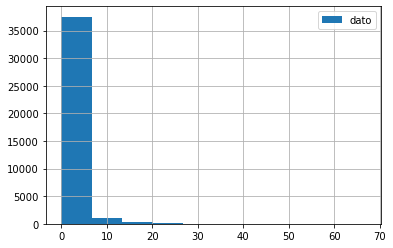

In [34]:
print('           ESTADISCIAS DEL DS_1_EST \n')

print(f'Flags       : {dfLimpioREG_EST["flag"].unique()}')
print(f'Estaciones  : {len(dfLimpioREG_EST["codigo"].unique())}')
print(f'Totales     : {dfLimpioREG_EST["dato"].count()}')
print(f'Ceros       : {dfLimpioREG_EST[dfLimpioREG_EST["dato"]==0]["dato"].count()}')
print(f'Entre 0 y 1 : {dfLimpioREG_EST[(dfLimpioREG_EST["dato"]>0) & (dfLimpioREG_EST["dato"]<1)]["dato"].count()}')
print(f'Mayores a 1 : {dfLimpioREG_EST[dfLimpioREG_EST["dato"]>10]["dato"].count()}')
print(f'Maximo      : {dfLimpioREG_EST["dato"].max()}')
print(f'Media       : {dfLimpioREG_EST["dato"].mean()}')
print(f'STD         : {dfLimpioREG_EST["dato"].std()}')

#_dataset[_dataset["dato"]!=0]["dato"].hist(legend=True)
#_dataset[_dataset["dato"]>1]["dato"].hist(legend=True)
dfLimpioREG_EST['dato'].hist(legend=True)

In [35]:
"""
Regresion
"""
comentarioREG_V2 = 'El dataset es para lso modelos de regresion, se usa como output el dato \
            Se ha realizado una limpieza de datos (quitado datos malos 1 y verificado que exista \
            las imagenes satelitales). ADICIONALMENTE, La version 2, es ya que solo se escojen los datos elevados \
            > 1, con un porcentaje pequeño de ceros'

p_reg_v2 = {    
    # parametros del proyecto
    'products'   : products,
    'times'      : times,
    'path_base'  : path_base,

    # parametros del dataset
    'ceros'      : 0.1,   
    'flags'      : ['C0000002'],
    'flagV2'     : ['D01','D02','C01'],
    'estaciones' : [],
    'delete'     : True,
    
    # Split
    'pruebas'    : 0.01,
    'validacion' : 0.2,
    
    # Modelo
    'redTipo'    : 'Regresion',
    
    # PARA MODELOS DE CLASIFICACION
    'claseName'  : '',
    'condicion_1': [],    
    
    # Nombres
    'nameDS'     : 'Dato_V2',       
}

12635


<AxesSubplot:>

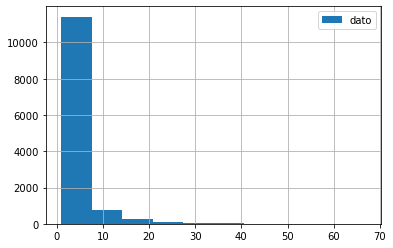

In [36]:
limit = 1
print(dfLimpioREG_EST[dfLimpioREG_EST['dato']>limit]['dato'].count())
dfREG_V2 = dfLimpioREG_EST[dfLimpioREG_EST['dato']>limit]
dfREG_V2['dato'].hist(legend=True)

In [37]:
dfLimpioREG_V2 = getModelo_DS(dfREG_V2,path_imagenes, p_reg_v2 ,comentario=comentarioREG_V2, read=False)

Tipo de dataset: Regresion
Se leera los archivos de datasets...
Tiempo tomado: 0.00s
+Cantidad de datos leidos 12635

Se elimnara los valores nulos y dudosos


C:\Users\Shounen\AppData\Local\Temp\ipykernel_13028\1950932386.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dsCompleto.dropna(subset=['dato'], axis='index', inplace=True)


Tiempo tomado: 0.36s
+Cantidad de datos luego de elimnar nulos 12635

Se buscara las imagenes satelitales para los datos...
0/12635 datos eliminados: No se encontraron los archivos de imagenes satelitales
Tiempo tomado en verificar datos: 2.25s
Tiempo tomado: 2.62s

Se limitara el numero de ceros al 10.00 porciento...
+Cantidad de datos luego de limtar ceros 12635

Se agregara los datos de las estaciones(cordenadas, umbral)...
-------> CANTIDAD FINAL DE DATOS :  12635 <--------------
Tiempo total: 2.78s
Tamaño de los datasets: 
TRAIN   : 10006
VALID   : 2502
PRUEBAS : 127


           ESTADISCIAS DEL DS_REG_2 

Flags       : ['C0000002']
Estaciones  : 144
Totales     : 12635
Ceros       : 0
Entre 0 y 1 : 0
Mayores a 1 : 793
Maximo      : 66.9
Media       : 3.757489513256826
STD         : 4.413612288610599


<AxesSubplot:>

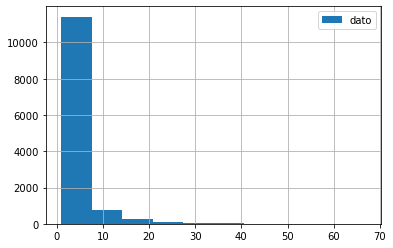

In [38]:
print('           ESTADISCIAS DEL DS_REG_2 \n')

print(f'Flags       : {dfLimpioREG_V2["flag"].unique()}')
print(f'Estaciones  : {len(dfLimpioREG_V2["codigo"].unique())}')
print(f'Totales     : {dfLimpioREG_V2["dato"].count()}')
print(f'Ceros       : {dfLimpioREG_V2[dfLimpioREG_V2["dato"]==0]["dato"].count()}')
print(f'Entre 0 y 1 : {dfLimpioREG_V2[(dfLimpioREG_V2["dato"]>0) & (dfLimpioREG_V2["dato"]<1)]["dato"].count()}')
print(f'Mayores a 1 : {dfLimpioREG_V2[dfLimpioREG_V2["dato"]>10]["dato"].count()}')
print(f'Maximo      : {dfLimpioREG_V2["dato"].max()}')
print(f'Media       : {dfLimpioREG_V2["dato"].mean()}')
print(f'STD         : {dfLimpioREG_V2["dato"].std()}')

#_dataset[_dataset["dato"]!=0]["dato"].hist(legend=True)
#_dataset[_dataset["dato"]>1]["dato"].hist(legend=True)
dfLimpioREG_V2['dato'].hist(legend=True)

In [39]:
"""
Regresion
"""
comentarioREG_V3 = 'El dataset es para lso modelos de regresion, se usa como output el dato \
            Se ha realizado una limpieza de datos (quitado datos malos 1 y verificado que exista \
            las imagenes satelitales). ADICIONALMENTE, La version 3, es ya que solo se escojen los datos pequños \
            < 1, con un porcentaje pequeño de ceros'

p_reg_v3 = {    
    # parametros del proyecto
    'products'   : products,
    'times'      : times,
    'path_base'  : path_base,

    # parametros del dataset
    'ceros'      : 0.1,   
    'flags'      : ['C0000002'],
    'flagV2'     : ['D01','D02','C01'],
    'estaciones' : [],
    'delete'     : True,
    
    # Split
    'pruebas'    : 0.01,
    'validacion' : 0.2,
    
    # Modelo
    'redTipo'    : 'Regresion',
    
    # PARA MODELOS DE CLASIFICACION
    'claseName'  : '',
    'condicion_1': [],    
    
    # Nombres
    'nameDS'     : 'Dato_V3',       
}

25328


<AxesSubplot:>

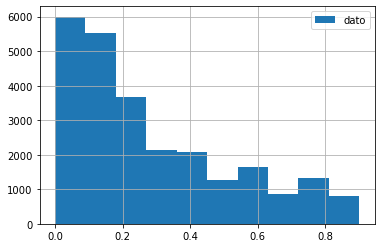

In [60]:
limit = 1
print(dfLimpioREG_EST[dfLimpioREG_EST['dato']<limit]['dato'].count())
dfREG_V3 = dfLimpioREG_EST[dfLimpioREG_EST['dato']<limit]
dfREG_V3['dato'].hist(legend=True)

In [61]:
dfLimpioREG_V3 = getModelo_DS(dfREG_V3,path_imagenes, p_reg_v3 ,comentario=comentarioREG_V3, read=False)

Tipo de dataset: Regresion
Se leera los archivos de datasets...
Tiempo tomado: 0.00s
+Cantidad de datos leidos 25328

Se elimnara los valores nulos y dudosos
Tiempo tomado: 0.02s
+Cantidad de datos luego de elimnar nulos 25328

Se buscara las imagenes satelitales para los datos...


C:\Users\Shounen\AppData\Local\Temp\ipykernel_5760\1950932386.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dsCompleto.dropna(subset=['dato'], axis='index', inplace=True)


0/25328 datos eliminados: No se encontraron los archivos de imagenes satelitales
Tiempo tomado en verificar datos: 2.67s
Tiempo tomado: 2.69s

Se limitara el numero de ceros al 10.00 porciento...
+Cantidad de datos luego de limtar ceros 19930

Se agregara los datos de las estaciones(cordenadas, umbral)...
-------> CANTIDAD FINAL DE DATOS :  19930 <--------------
Tiempo total: 2.94s
Tamaño de los datasets: 
TRAIN   : 15783
VALID   : 3947
PRUEBAS : 200


           ESTADISCIAS DEL DS_1_V3 

Flags       : ['C0000002']
Estaciones  : 150
Totales     : 19930
Ceros       : 600
Entre 0 y 1 : 19330
Mayores a 1 : 0
Maximo      : 0.9
Media       : 0.3399668840943302
STD         : 0.2510828751095747


<AxesSubplot:>

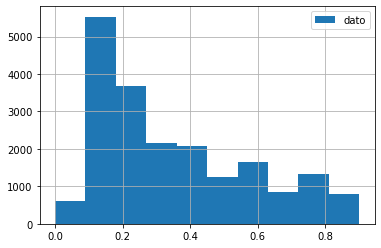

In [62]:
print('           ESTADISCIAS DEL DS_1_V3 \n')

print(f'Flags       : {dfLimpioREG_V3["flag"].unique()}')
print(f'Estaciones  : {len(dfLimpioREG_V3["codigo"].unique())}')
print(f'Totales     : {dfLimpioREG_V3["dato"].count()}')
print(f'Ceros       : {dfLimpioREG_V3[dfLimpioREG_V3["dato"]==0]["dato"].count()}')
print(f'Entre 0 y 1 : {dfLimpioREG_V3[(dfLimpioREG_V3["dato"]>0) & (dfLimpioREG_V3["dato"]<1)]["dato"].count()}')
print(f'Mayores a 1 : {dfLimpioREG_V3[dfLimpioREG_V3["dato"]>10]["dato"].count()}')
print(f'Maximo      : {dfLimpioREG_V3["dato"].max()}')
print(f'Media       : {dfLimpioREG_V3["dato"].mean()}')
print(f'STD         : {dfLimpioREG_V3["dato"].std()}')

#_dataset[_dataset["dato"]!=0]["dato"].hist(legend=True)
#_dataset[_dataset["dato"]>1]["dato"].hist(legend=True)
dfLimpioREG_V3['dato'].hist(legend=True)

In [ ]:
"""
TEMPORALES - SE PUEDE BORRAR
"""

In [124]:
dfAnaTotalTemp = dfAnaTotal.copy()
dfAnaTotalTemp['porcM1'] = dfAnaTotalTemp['cantM01'] /dfAnaTotalTemp['count']

dfAnaTotalTemp.sort_values('cantM02',ascending=False)[['Codigo','count','cantM02', 'porcM1']]

,Codigo,count,cantM02,porcM1
160,X4729658E,2624,840,0.008003
128,X47271776,8723,743,0.001376
41,X47E1F02E,7862,513,0.000127
15,X472F43AC,8743,313,0.000686
151,X472935F2,7341,214,0.000545
...,...,...,...,...
78,X472EC742,8750,0,0.000114
79,X472E24B0,8749,0,0.000457
80,X47E33064,8750,0,0.000229
81,X472CA750,8751,0,0.000343
